# Setup

In [2]:
import json
import os
import sys
import pickle
import warnings

sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import ElasticNet, ElasticNetCV, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import classification_report, roc_auc_score, balanced_accuracy_score
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error, median_absolute_error

from utils import read_csv_non_utf, preprocess_data, get_zero_nonzero_datasets, test_thresholds, ratios_to_DI_cats, \
                  get_train_test_split
from model_utils import HurdleModelEstimator
from plotting_utils import plot_ratio_confusion_matrix, plot_model_coefficients, plot_ratio_distribution_comparison, \
                           plot_ratio_scatterplot
from performance_reports import get_classification_report, get_regression_report

In [3]:
# Loading in general configuration
with open('../config.json', 'r') as f:
    config = json.load(f)

# Getting filepaths
gdrive_fp = config['gdrive_path']
LIFE_fp = config['LIFE_folder']
dataset_fp = config['datasets_path']
benitez_lopez2019 = config['indiv_data_paths']['benitez_lopez2019']

data_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, benitez_lopez2019)

In [4]:
# Reading in data as a pandas dataframe
ben_lop2019 = read_csv_non_utf(data_path)

# Fixed effects linear hurdle model

I believe this will more accurately capture generalisation behavior, since we will not be able to make use of the random effects in the original mixed effects models--new species and countries will represent unseen levels on those categorical variables. See [this stackoverflow post](https://stackoverflow.com/questions/29259750/prediction-with-lme4-on-new-levels) for an explanation of `lme4`'s behavior with new levels.

In [34]:
# Modeling parameters
save_model = False
from_save = True
model_save_folder = '../model_saves/hurdle_models'
model_save_fp = 'LR_ElasticNet_only_indicators'

train_size = 0.7

extirp_pos = False
verbose = True

cv = 5 # either int or None... if None, we'll just skip cross-validation
logistic_penalty = 'l1'

#  columns to use for each model 
#   - if None, will use defaults (i.e., Ana's vars)
#   - if an empty list, will not use any vars
indicator_columns = ['Diet']
nonzero_columns = ['BM', 'DistKm', 'PopDens', 'Stunting', 'TravTime', 'LivestockBio', 'Literacy', 'Reserve']
zero_columns = nonzero_columns

polynomial_features = 0

#  hyperparameters for grid search
l1_ratio = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
Cs = 20

# Putting all relevant params into a dictionary for saving purposes
param_dict = {'model_save_fp' : model_save_fp,
              'extirp_pos' : extirp_pos,
              'logistic_penalty' : logistic_penalty,
              'indicator_columns' : indicator_columns,
              'nonzero_columns' : nonzero_columns,
              'zero_columns' : zero_columns,
              'l1_ratio' : l1_ratio,
              'Cs' : Cs,
              'polynomial_features' : polynomial_features}

In [32]:
# Getting the shared basic train/test split
idxs = get_train_test_split(len(ben_lop2019), train_size = train_size)

# Pre-processing data
pp_data = preprocess_data(ben_lop2019, include_indicators = True, standardize = True, log_trans_cont = False,
                          polynomial_features = polynomial_features, train_test_idxs = idxs)

#  splitting the actual dataset into train/test sets
train_data, test_data = pp_data.loc[idxs['train']], pp_data.loc[idxs['test']]

# Defining sub-models for hurdle model or read in saved model
if not from_save:
    data_args = {'indicator_columns' : indicator_columns,
                 'nonzero_columns' : nonzero_columns,
                 'zero_columns' : zero_columns}
    
    if cv is not None:
        print('Using cross-validation')
        nonzero_model = ElasticNetCV(cv = cv, l1_ratio = l1_ratio, max_iter = 5000)
        zero_model = LogisticRegressionCV(cv = cv, Cs = Cs, penalty = logistic_penalty, solver = 'saga', max_iter = 500)
    else:
        print('Using single models')
        nonzero_model = ElasticNet(alpha = 0.003, l1_ratio = 0.1, max_iter = 5000)
        zero_model = LogisticRegression(C = 0.616, penalty = 'l1', solver = 'saga', max_iter = 500)
    
    hurdle_model = HurdleModelEstimator(zero_model, nonzero_model, extirp_pos = extirp_pos, verbose = verbose,
                                        data_args = data_args)

    # Fitting on the training data
    with warnings.catch_warnings(action = 'ignore'):
        hurdle_model.fit(train_data)

    # Tuning the probability threshold for the classification model
    X_zero, y_zero, _, _ = get_zero_nonzero_datasets(train_data, extirp_pos = False, pred = False, **data_args)
    
    y_pred_zero = hurdle_model.zero_model.predict_proba(X_zero)
    y_pred_zero = y_pred_zero[ : , 1]
    y_true_zero = y_zero
    
    opt_thresh, metrics = test_thresholds(y_pred_zero, y_true_zero)
    print(f'Best threshold was found to be {round(opt_thresh, 3)} with a TSS of {round(np.max(metrics["TSS"]), 3)}')
    
    # Setting the threshold to the optimal in the hurdle model
    hurdle_model.prob_thresh = round(opt_thresh, 3)

    # Optionally saving the model and hyperparameters
    if save_model:
        print('Saving model...')

        os.mkdir(os.path.join(model_save_folder, model_save_fp))
        with open(os.path.join(model_save_folder, model_save_fp, model_save_fp + '.pkl'), 'wb') as f:
            pickle.dump(hurdle_model, f)
            
        with open(os.path.join(model_save_folder, model_save_fp, model_save_fp + '.json'), 'w') as f:
            json.dump(param_dict, f, sort_keys = True, indent = 4)
else:
    save_path = os.path.join(model_save_folder, model_save_fp, model_save_fp + '.pkl')
    print(f'Loading saved model from {save_path}')
    with open(save_path, 'rb') as f:
        hurdle_model = pickle.load(f)

# Predicting on the test set
pred_ratios = hurdle_model.predict(test_data)
test_ratios = test_data['ratio']

#  back-transforming to recover actual abundance ratios predicted by the hurdle model
pred_ratios[pred_ratios != 0] = np.exp(pred_ratios[pred_ratios != 0])
pred_DI_cats = ratios_to_DI_cats(pred_ratios)
true_DI_cats = ratios_to_DI_cats(test_ratios)

Loading saved model from ../model_saves/hurdle_models/LR_ElasticNet_only_indicators/LR_ElasticNet_only_indicators.pkl


CLASSIFICATION PERFORMANCE
--------------------------
              precision    recall  f1-score   support

         low       0.73      0.38      0.50       560
      medium       0.25      0.54      0.34       207
        high       0.39      0.44      0.41       218

    accuracy                           0.43       985
   macro avg       0.46      0.45      0.42       985
weighted avg       0.55      0.43      0.45       985

Balanced accuracy: 45.27%


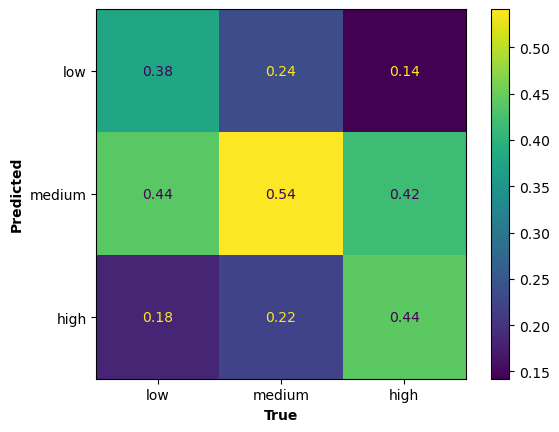


REGRESSION PERFORMANCE
----------------------
Mean absolute error: 0.936
Median absolute error: 0.372
Root mean squared error: 3.463
Root median squared error: 0.372


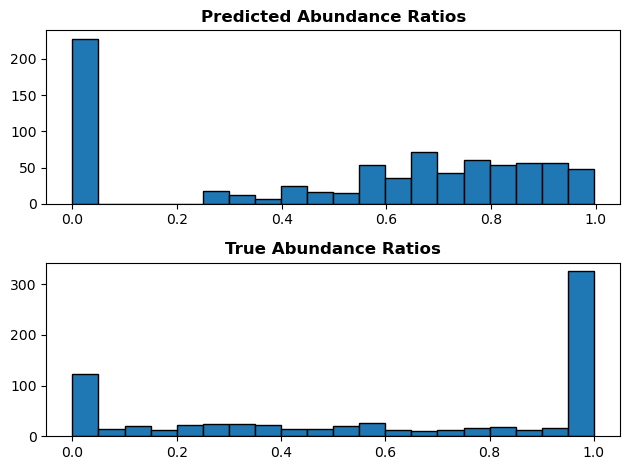

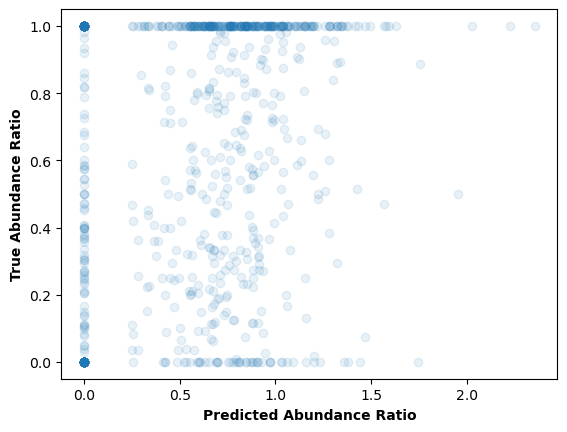

In [33]:
# Evaluation: classification and regression performance
print('CLASSIFICATION PERFORMANCE')
print('--------------------------')
get_classification_report(true_DI_cats, pred_DI_cats, save_dir = model_save_folder, 
                          model_name = model_save_fp, printout = True)
print()

print('REGRESSION PERFORMANCE')
print('----------------------')
get_regression_report(test_ratios, pred_ratios, save_dir = model_save_folder, 
                      model_name = model_save_fp, printout = True)

## Inspecting learned patterns

### Logistic regression

In [13]:
# Seeing the tuned hyperparam value
best_C = round(hurdle_model.zero_model.C_[0], 3)
print('Logistic regression: best L1 regularization strength (C, lower is higher strength)', best_C)

Logistic regression: best L1 regularization strength (C, lower is higher strength) 0.0


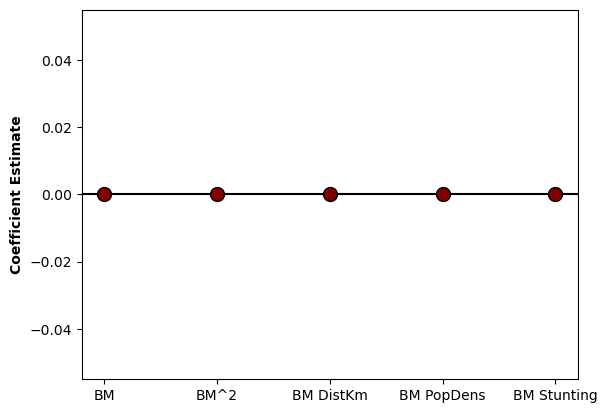

In [14]:
# Taking a look at the coefficient estimates for the spatial predictors
#  - remember: the positive class is locally EXTANT, so a positive coef means there 
#    is a higher chance of avoiding local extirpation
spatial_predictors = hurdle_model.zero_model.feature_names_in_[ : 5]
spatial_coefs = hurdle_model.zero_model.coef_[0, : 5]

fig, ax = plot_model_coefficients(spatial_predictors, spatial_coefs)

In [15]:
# For the indicator-only model: inspecting the weights
feats = hurdle_model.zero_model.feature_names_in_
coefs = hurdle_model.zero_model.coef_[0]

print(f'In total, {(coefs != 0).sum()} features were retained')
print()

for i in range(len(feats)):
    if coefs[i] != 0:
        print(f'{feats[i]}: {round(coefs[i], 3)}')
        if i != len(feats) - 1:
            if (feats[i].split('_')[0] != feats[i + 1].split('_')[0]):
                print()

In total, 0 features were retained



### ElasticNet

In [9]:
# Seeing the tuned hyperparam values
best_alpha = round(hurdle_model.nonzero_model.alpha_, 3)
best_l1_ratio = hurdle_model.nonzero_model.l1_ratio_
print('ElasticNet: best L1/L2 regularization strength (alpha, higher is higher strength)', best_alpha)
print('ElasticNet: best L1 ratio (0 = ridge, 1 = LASSO)', best_l1_ratio)

ElasticNet: best L1/L2 regularization strength (alpha, higher is higher strength) 0.005
ElasticNet: best L1 ratio (0 = ridge, 1 = LASSO) 1.0


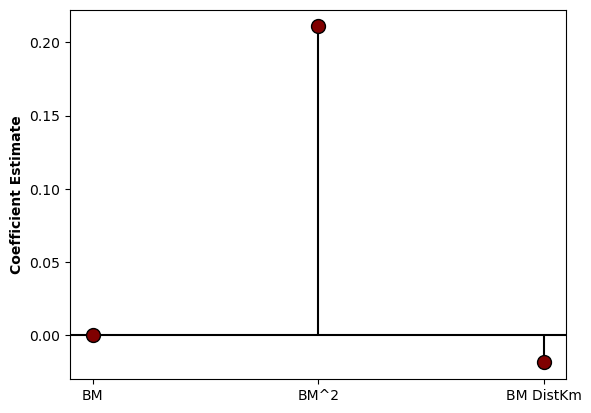

In [10]:
# Taking a look at the coefficient estimates for the spatial predictors
spatial_predictors = hurdle_model.nonzero_model.feature_names_in_[ : 3]
spatial_coefs = hurdle_model.nonzero_model.coef_[ : 3]

fig, ax = plot_model_coefficients(spatial_predictors, spatial_coefs)

In [11]:
# For the indicator-only model: inspecting the weights
feats = hurdle_model.nonzero_model.feature_names_in_
coefs = hurdle_model.nonzero_model.coef_

print(f'In total, {(coefs != 0).sum()} features were retained')
print()

for i in range(len(feats)):
    if coefs[i] != 0:
        print(f'{feats[i]}: {round(coefs[i], 3)}')
        if i != len(feats) - 1:
            if (feats[i].split('_')[0] != feats[i + 1].split('_')[0]):
                print()

In total, 24 features were retained

BM^2: 0.211

BM DistKm: -0.018

BM PopDens: 0.03

BM Stunting: -0.064

BM TravTime: 0.049

BM LivestockBio: 0.001

BM Literacy: -0.238

DistKm: 0.106

DistKm TravTime: -0.065

DistKm LivestockBio: 0.029

PopDens: -0.038

PopDens^2: 0.17

PopDens TravTime: 0.001

PopDens Literacy: -0.235

Stunting^2: 0.032

Stunting LivestockBio: -0.029

Stunting Literacy: 0.066

TravTime^2: 0.053

LivestockBio^2: 0.049

Literacy: -0.007

Reserve: 0.098

Diet_Frug: -0.223
Diet_Herb: -0.258
Diet_Omn: 0.01


# ML-based hurdle models

Might as well do a cross-validated search for the best model for each component of the hurdle model.